![for sale image, from https://time.com/5835778/selling-home-coronavirus/](https://api.time.com/wp-content/uploads/2020/05/selling-home-coronavirus.jpg?w=800&quality=85)

# Project Title

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Questions to consider:

- Need to fill this out
- Who are your stakeholders?
- What are your stakeholders' pain points related to this project?
- Why are your predictions important from a business perspective?

## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

### Data Understanding Summary

- The data represents ~22K home sales in Kings County, Washington from September 2014 through January 2015
- It's unclear whether this is just single family homes or if multi family / condominiums are included as well
- The data includes the sale price of the home and a number of descriptors, including many variables about size (number of rooms, square footage, lot size), location (zip code, lat / lon), and other attributes (waterfront, basement, etc).

In [248]:
# Standard imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Import functions to run and evaluate regression models
from util import run_model, evaluate_model

In [4]:
# Import data

df_sales = pd.read_csv('kc_house_data.csv')

In [150]:
df_sales['floors'].value_counts()

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

In [18]:
# Run info to check for general data types and nulls

df_sales.info()

# Summary: all are numbers except Date and Basement_sqft. The latter should probably be converted to a number.
# Some of the numbers are likely categorical and need to be treated as such.
# 22K entries total. Most columns do not contain nulls (will need to clean up waterfront and yr_renovated)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [29]:
# Dependent variable will be 'price'

### Non-numeric data exploration

Covering date and sqft_basement

In [17]:
# This dataset contains home sales from September 2014 through January 2015.
# Will not likely use 

latest_date = df_sales['date'].min()
earliest_date = df_sales['date'].max()

sorted_date = df_sales['date'].sort_values(ascending=False)

print(earliest_date, latest_date)

9/9/2014 1/10/2015


In [28]:
# There are 304 unique values here. 12K of them are 0. 
# Two steps:
# Converted to numerical
# Used to create a new binary categorical variable "has_basement"

print(len(df_sales['sqft_basement'].unique()))
(df_sales['sqft_basement'] == '0.0').sum()

304


12826

### Categorical variables

Exploring which fields are categorical, and how to deal with them

In [32]:
# Based column description, there are a few existing categorical variables and a few fields that we may want
# to transform into categorical variables

# Existing categorical variables
existing_cat = ['waterfront', 'view', 'zipcode']

# Fields we may want to transform into categorical variables
potential_cat = ['yr_built', 'yr_renovated', 'sqft_basement', 'floors']

# yr_built: could divide in binary variable called "recently built" to show developer new houses sell well
# sqft_basement: transform into variable showing whether there's a basement or not
# yr_renovated: transform into whether the house has been renovated or not
# floors: transform into binary variable for having multiple stories or not

### Outliers

Identifying outliers among the data

In [35]:
df_sales.describe().apply(lambda s: s.apply('{0:.0f}'.format))

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597,21597,21597,21597,21597,21597,21597,19221,21534,21597,21597,21597,21597,17755,21597,21597,21597,21597,21597
mean,4580474288,540297,3,2,2080,15099,1,0,0,3,8,1789,1971,84,98078,48,-122,1987,12758
std,2876735716,367368,1,1,918,41413,1,0,1,1,1,828,29,400,54,0,0,685,27274
min,1000102,78000,1,0,370,520,1,0,0,1,3,370,1900,0,98001,47,-123,399,651
25%,2123049175,322000,3,2,1430,5040,1,0,0,3,7,1190,1951,0,98033,47,-122,1490,5100
50%,3904930410,450000,3,2,1910,7618,2,0,0,3,7,1560,1975,0,98065,48,-122,1840,7620
75%,7308900490,645000,4,2,2550,10685,2,0,0,4,8,2210,1997,0,98118,48,-122,2360,10083
max,9900000190,7700000,33,8,13540,1651359,4,1,4,5,13,9410,2015,2015,98199,48,-121,6210,871200


In [90]:
# There appear to be outliers in 'bedrooms', 'grade', and 'sqft_lot' based on max values

# Bedroom outlier check
bedroom_outlier = df_sales[df_sales['bedrooms'] == 33]

bedroom_outlier

# Conclusion: seems to be a typo. Filter for everything with fewer than 8 bedrooms as our developer is 
# unlikely to want to build these properties

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


In [88]:
df_sales['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [39]:
# Grade outlier check

df_sales['grade'].value_counts()

# Conclusion: not actually an outlier. Grades go up to 13 and indicate the quality of materials used.

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

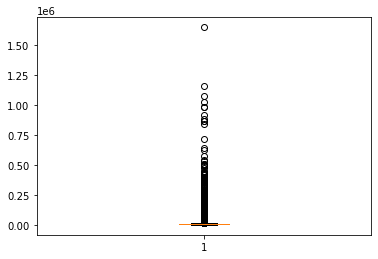

In [42]:
# Sqft_lot check

plt.boxplot(df_sales['sqft_lot']);

# Conclusion: while possible a valid entry, 1.6mm square feet converts to 38 acres.
# The developer is unlikely to consider building on property more than a few acres large.
# Can probably apply a filter of 200K square feet for lot size (~4.5 acres). This covers 99% of the dataset

In [45]:
num = 200000

len(df_sales[df_sales['sqft_lot'] < num]) / len(df_sales)

0.9880538963744965

### Null values

Determining what to do with Nulls

In [47]:
df_sales.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [48]:
# View
# Conclusion: Given the overwhelming tendency towards 0, replace the null values with 0

df_sales['view'].value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [49]:
# Waterfront
# Conclusion: replace these nulls with 0 given overwhelming tendency in that direction

df_sales['waterfront'].value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [51]:
# yr_renovated
# Conclusion: null values here probably mean the home hasn't been renovated, replace with zero.

df_sales['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Null values for views, waterfront, and yr_renovated were replaced with the most common value
- Thresholds were set to control for outliers due to either data entry errors or properties that are out of scope for our analysis
- [Were there variables you dropped or created?] TBD
- [Why are these choices appropriate given the data and the business problem?] TBD

In [134]:
sales_clean = df_sales.copy()

### Null values

- Replacing view, waterfront, and yr_renovated with their most common value

In [135]:
# Replace nulls in view, yr_renovated, and waterfront with its most common value

from sklearn.impute import SimpleImputer

columns_to_replace = ['view', 'yr_renovated', 'waterfront']

for col in columns_to_replace:
    imputer = SimpleImputer(strategy='most_frequent')
    to_impute = sales_clean[[col]]
    col_imputed = imputer.fit_transform(to_impute)
    sales_clean[col] = col_imputed

### Outliers

In [136]:
# Set thresholds to filter dataset down for outliers

max_bedrooms = 8
max_sq_ft = 200000

sales_clean = sales_clean[sales_clean['bedrooms'] <= max_bedrooms]
sales_clean = sales_clean[sales_clean['sqft_lot'] <= max_sq_ft]

### Create categorical variables

In [137]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [139]:
recent_build = 2005

# Was the house built after the year defined above (1) or not (0)
sales_clean['recent_build'] = 0
sales_clean['recent_build'].loc[sales_clean['yr_built'] >= recent_build] = 1


# Has the house been renovated (1) or not (0)
sales_clean['is_renovated'] = 0
sales_clean['is_renovated'].loc[sales_clean['yr_renovated'] != 0] = 1

# Has the house been renovated after year defined above (1) or not (0)
# Removing this because there are no recently renovated homes
# sales_clean['recent_renovation'] = 0
# sales_clean.loc[(sales_clean['is_renovated'] == 1) & (sales_clean['yr_built'] >= recent_build),
#                'recent_renovation'] = 1

In [143]:
sales_clean.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,recent_build,is_renovated
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,0,1
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,0,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,0,0


### Histograms of numerical variables

Test for normality and seew hich variables we need to log transform

### Check for linear relationships between independent variables and home price

### Check for collinearity among independent variables

### Standardize variables

## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How did you analyze the data to arrive at an initial approach?
- How did you iterate on your initial approach to make it better?
- Why are these choices appropriate given the data and the business problem?

In [192]:
# Create the train and test datasets
from sklearn.model_selection import train_test_split

y = sales_clean['price']
X = sales_clean.drop(columns=['id','price'], axis=1)

# Split the data out, specifying size of the split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.20,
                                                    random_state=5
)

# Merge back together into one Train and Test dataset
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [149]:
# Linear reegression imports

from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics

In [249]:
train_target_mean = y_train.mean()

In [250]:
baseline_train_preds = [train_target_mean] * len(y_train)
baseline_test_preds = [train_target_mean] * len(y_test)

In [251]:
# R squared
print('Model fit for training data')
print(f"R2: {metrics.r2_score(y_train, baseline_train_preds):.2f}")
# Mean squared error
print(f"MSE: {metrics.mean_squared_error(y_train, baseline_train_preds, squared=False):,.0f}")
# Mean absolute error
print(f"MAE: {metrics.mean_absolute_error(y_train, baseline_train_preds):,.0f}")
print("\n")

# R squared
print('Model fit for test data')
print(f"R2: {metrics.r2_score(y_test, baseline_test_preds):.2f}")
# Mean squared error
print(f"MSE: {metrics.mean_squared_error(y_test, baseline_test_preds, squared=False):,.0f}")
# Mean absolute error
print(f"MAE: {metrics.mean_absolute_error(y_test, baseline_test_preds):,.0f}")


Model fit for training data
R2: 0.00
MSE: 372,566
MAE: 234,829


Model fit for test data
R2: -0.00
MSE: 343,162
MAE: 228,344


### Simple model

First model will test price vs. its most correlated feature

In [144]:
df_train.corr().price.sort_values(ascending=False)

price            1.000000
sqft_living      0.702489
grade            0.667823
sqft_above       0.600260
sqft_living15    0.584779
bathrooms        0.520157
view             0.392867
bedrooms         0.317883
lat              0.313723
waterfront       0.253360
floors           0.249247
sqft_lot         0.116594
yr_renovated     0.115271
sqft_lot15       0.084122
yr_built         0.053086
condition        0.035878
long             0.012341
id              -0.018504
zipcode         -0.045647
Name: price, dtype: float64

In [253]:
model_output, train_preds, test_preds = run_model(df_train, df_test, ['sqft_living'])

model_output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                 1.689e+04
Date:                Mon, 04 Oct 2021   Prob (F-statistic):               0.00
Time:                        22:27:35   Log-Likelihood:            -2.3721e+05
No. Observations:               17062   AIC:                         4.744e+05
Df Residuals:                   17060   BIC:                         4.744e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -5.952e+04   5032.884    -11.826      0.000   -6.94e+04   -4.97e+04
sqft_living   289.4596      2.227    129.968      0.000     285.094     293.825
==============================================================================
Omnibus:                    11669.280   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           427592.075
Skew:                           2.808   Prob(JB):                         0.00
Kurtosis:                      26.873   Cond. No.                     5.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Train R2: 0.498
Test R2: 0.463
****
Train RMSE: 264,096
Test RMSE: 251,379
****
Train MAE: 175,933
Test MAE: 172,038

Residual scatter plot:


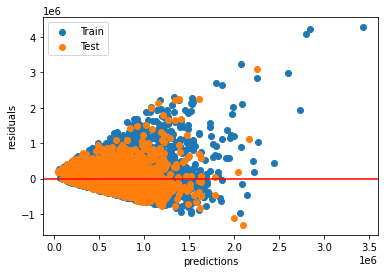



Residual qq plot


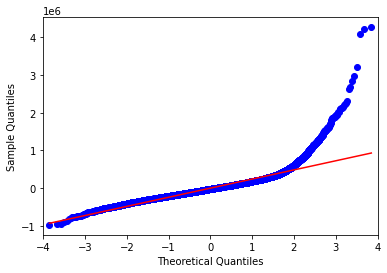

In [247]:
evaluate_model(df_train, df_test, ['sqft_living'])

### Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

In [ ]:
# code here to iteratively improve your models

In [ ]:
# code here to evaluate your iterations

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [ ]:
# code here to show your final model

In [ ]:
# code here to evaluate your final model

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
